In [2]:
import re
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolHash, rdmolops
from Bio.SeqUtils import seq3 as seq12seq3
from Bio.SeqUtils import seq1 as seq32seq1
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def tranDict(dict_):
    return {value:key for (key,value) in dict_.items()}


protein_letters_1to3 = {
    "A": "ala",
    #"B": "asx", # aspartic acid or asparagine (D or N)
    "C": "cys",
    "D": "asp",
    "E": "glu",
    "F": "phe",
    "G": "gly",
    "H": "his",
    "I": "ile",
    "K": "lys",
    "L": "leu",
    "M": "met",
    "N": "asn",
    "O": "pyl",  # pyrrolysine
    "P": "pro",
    "Q": "gln",
    "R": "arg",
    "S": "ser",
    "T": "thr",
    "U": "sec", # selenocysteine
    "V": "val",
    "W": "trp",
    "Y": "tyr",
    #"X": "Xaa", # unknown or 'other' amino acid
    "Z": "glx" # glutamic acid or glutamine (E or Q)
    #"J": "Xle", # leucine or isoleucine (L or I, used in NMR)
}

protein_letters_3to1 = tranDict(protein_letters_1to3)

letter_3 = list(protein_letters_1to3.values())
letter_1 = list(protein_letters_1to3.keys())

Rs = {
    'A': 'C[C@H](N)C(=O)O', #'N[C@@H](C)C(=O)O'
    'C': 'N[C@@H](CS)C(=O)O',
    'D': 'N[C@@H](CC(=O)O)C(=O)O', #'N[C@@H](CC(=O)[O-])C(=O)O'
    'E': 'N[C@@H](CCC(=O)O)C(=O)O', # 'N[C@@H](CCC(=O)[O-])C(=O)O'
    'F': 'N[C@@H](Cc1ccccc1)C(=O)O', 
    'G': 'NCC(=O)O',
    'H': 'N[C@@H](Cc1c[nH]cn1)C(=O)O',
    'I': 'CC[C@H](C)[C@H](N)C(=O)O', # 'N[C@@H](C(C)CC)C(=O)O',
    'K': 'NCCCC[C@H](N)C(=O)O', # 'N[C@@H](CCCC[NH3+])C(=O)O'
    'L': 'CC(C)C[C@H](N)C(=O)O', # 'N[C@@H](CC(C)C)C(=O)O',
    'M': 'CSCC[C@H](N)C(=O)O', # 'N[C@@H](CCSC)C(=O)O',
    'N': 'NC(=O)C[C@H](N)C(=O)O', # 'N[C@@H](CC(=O)N)C(=O)O'
    'O': 'N1[C@@H](C[C@@H](O)C1)C(=O)O',
    'P': 'O=C(O)[C@@H]1CCCN1', # 'N1[C@@H](CCC1)C(=O)O',
    'Q': 'NC(=O)CC[C@H](N)C(=O)O', # 'N[C@@H](CCC(=O)N)C(=O)O'
    'R': 'N=C(N)NCCC[C@H](N)C(=O)O', # 'N[C@@H](CCCN:C(:N):N)C(=O)O',
    'S': 'N[C@@H](CO)C(=O)O',
    'T': 'C[C@@H](O)[C@H](N)C(=O)O', # 'N[C@@H](C(O)C)C(=O)O',
    'U': 'O=C(O)[C@@H](N)C[SeH]',
    'V': 'CC(C)[C@H](N)C(=O)O', # N[C@@H](C(C)C)C(=O)O',
    'W': 'N[C@@H](Cc1c[nH]c2ccccc12)C(=O)O', 
    'Y': 'N[C@@H](Cc1ccc(O)cc1)C(=O)O', 
    'Z': 'C(CC(=O)N)[C@@H](C(=O)O)N', # 'N1[C@@H](CCC1(=O))C(=O)O'
    'A001': 'CC(C1=CC=C(C=C1)C[C@@H](C(O)=O)N)=O',
    'A002': 'OC([C@H](CC1=C(C(C)=O)C=CC=C1)N)=O',
    'A003': 'N[C@H](C(O)=O)CC1=CC=C(C=C1)C(C2=CC=CC=C2)=O'

    # 'a': 'N[C@H](C)C(=O)O',
    # 'r': 'N[C@H](CCCN:C(:N):N)C(=O)O',
    # 'n': 'N[C@H](C(=O)N)C(=O)O',
    # 'd': 'N[C@H](C(=O)O)C(=O)O', # N[C@H](C(=O)[O-])C(=O)O
    # 'c': 'N[C@H](CS)C(=O)O',
    # 'q': 'N[C@H](CC(=O)N)C(=O)O',
    # 'e': 'N[C@H](CC(=O)[O-])C(=O)O',
    # 'h': 'N[C@H](Cc1nc[nH]c1)C(=O)O',
    # 'i': 'N[C@H](C(C)CC)C(=O)O',
    # 'l': 'N[C@H](CC(C)C)C(=O)O',
    # 'k': 'NCCCC[C@H](N)C(=O)O', #'N[C@H](CCCC[NH3+])C(=O)O'
    # 'm': 'N[C@H](CCSC)C(=O)O',
    # 'f': 'N[C@H](Cc1ccccc1)C(=O)O',
    # 'p': 'N1[C@H](CCC1)C(=O)O',
    # 's': 'N[C@H](CO)C(=O)O',
    # 't': 'N[C@H](C(O)C)C(=O)O',
    # 'w': 'N[C@H](Cc1c2ccccc2[nH]c1)C(=O)O',
    # 'y': 'N[C@H](Cc1ccc(O)cc1)C(=O)O',
    #'v': 'N[C@H](C(C)C)C(=O)O',
    #'A(S)PRO': 'N1[C@@H](C[C@H](N)C1)C(=O)O',
    #'A(R)PRO': 'N1[C@@H](C[C@@H](N)C1)C(=O)O',
    #'STY': 'N[C@@H](Cc1ccc(OS(=O)(=O)O)cc1)C(=O)O',
    #'GLA': 'N[C@@H](C(C(=O)[O-])(C(=O)[O-]))C(=O)O'
    }

def readSmiles(smiles, addh=False):
    if isinstance(smiles, str):
        mol = Chem.MolFromSmiles(smiles)
    else:
        mol = smiles
    if addh:
        mol = Chem.AddHs(mol)
    return mol

def seq2smiRDKit(seq):
    mol = Chem.MolFromSequence(seq)
    print(Chem.MolToSmiles(mol))
    return mol

def countNeighbourAtomNumber(atom, s):
    count = 0
    for a in atom.GetNeighbors():
        if atom.GetSymbol()==s:
            count += 1
    return count

def getSubstructureAtomIndex(smiles, substructure_smiles):
    mol = readSmiles(smiles)
    substructure = Chem.MolFromSmarts(substructure_smiles)
    return list(mol.GetSubstructMatch(substructure))

def Nterm2Rgroup(smiles, r_index=1):
    mol = readSmiles(smiles, addh=True)
    hit_ats = getSubstructureAtomIndex(mol, '[H]OC(=O)[C@]([H])([*])N([H])[*]')
    for atom in mol.GetAtoms():
        if atom.GetIdx() in hit_ats:
            if atom.GetSymbol()=='H':
                nei = atom.GetNeighbors()
                if len(nei)==1 and nei[0].GetSymbol()=='N':
                    atom_N = nei[0].GetIdx()
                    atom_H = atom.GetIdx()
                    break
    bond_id = mol.GetBondBetweenAtoms(atom_N, atom_H).GetIdx()
    new_mol = Chem.FragmentOnBonds(mol, [bond_id])
    smi1, smi2 = Chem.MolToSmiles(new_mol).split('.')
    if len(smi1)>=len(smi2):
        smi = smi1
    elif len(smi2)>len(smi1):
        smi = smi2
    return re.sub('\[.*\*\]', f'[*:{r_index}]', smi)

def Cterm2Rgroup(smiles, r_index=1):
    mol = readSmiles(smiles)
    hit_ats = getSubstructureAtomIndex(mol, 'OC(=O)CN' )# N[C@@H](*)C(=O)O
    bond_id = None
        
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.SINGLE:
            if bond.GetBeginAtom().GetSymbol() == 'C' \
                and bond.GetEndAtom().GetSymbol() == 'O'\
                and bond.GetBeginAtom().GetIdx() in hit_ats\
                and bond.GetEndAtom().GetIdx() in hit_ats:
                bond_id = bond.GetIdx()
            elif bond.GetBeginAtom().GetSymbol() == 'O' \
                and bond.GetEndAtom().GetSymbol() == 'C'\
                and bond.GetBeginAtom().GetIdx() in hit_ats\
                and bond.GetEndAtom().GetIdx() in hit_ats:
                bond_id = bond.GetIdx()
    new_mol = Chem.FragmentOnBonds(mol, [bond_id])
    smi1, smi2 = Chem.MolToSmiles(new_mol).split('.')
    if len(smi1)>=len(smi2):
        smi = smi1
    elif len(smi2)>len(smi1):
        smi = smi2
    return re.sub('\[.*\*\]', f'[*:{r_index}]', smi)

def linkTwoAminoAcidResidues(r1, r2, ready_smiles=None):
    # r1 left residue, change COOH
    if ready_smiles is None:
        r1 = Cterm2Rgroup(r1)
    else:
        r1 = ready_smiles
    # r2 right residue, change NH2
    r2 = Nterm2Rgroup(r2)
    r2_ = Cterm2Rgroup(r2, r_index=2)
    
    # linked two fragment
    mol = Chem.MolFromSmiles('.'.join([r1, r2]))
    # linked two fragment ready for next amino acid residue
    mol_ = Chem.MolFromSmiles('.'.join([r1, r2_]))
    ready_smiles = Chem.MolToSmiles(rdmolops.molzip(mol_))
    ready_smiles = ready_smiles.replace('[*:2]', '[*:1]')
    return rdmolops.molzip(mol), ready_smiles

def MOL(smiles):
    return Chem.MolFromSmiles(smiles)

def smilesMW(smiles):
    return round(Descriptors.ExactMolWt(readSmiles(smiles)),2)

def smiles2formula(smiles):
    return rdMolHash.MolHash(readSmiles(smiles), rdMolHash.HashFunction.MolFormula)

def seqMW(seq):
    mol = Chem.MolFromFASTA(seq)
    return round(Chem.Descriptors.ExactMolWt(mol),2)

def seq2formula(seq):
    mol = Chem.MolFromFASTA(seq)
    return Chem.rdMolHash.MolHash(mol, Chem.rdMolHash.HashFunction.MolFormula)

def MingDuSeq2smi(seq, aard=None):
    """
    seq: sequence of amino acid residue
    aard: dictionary of amino acid residue name pair
    
    
    seq = 'Ala-A001-Cys-A003'
    seq = 'HAEGTFTSDVSSYLEGQAAREFIAWLVRGR'
    """
    seq = seq.strip()
    amino_names = None
    
    if '-' in seq:
        amino_names = seq.split('-')
        without_hyphen = False
    else:
        without_hyphen = True
        amino_names = list(seq)
    amino_names = [x for x in amino_names if x!='']
    
    # get all amino acid SMILES
    amino_smiles = []
    if aard is None:
        aard = Rs
    for name in amino_names:
        if name not in aard.keys():
            if name.lower() not in protein_letters_3to1.keys():
                if without_hyphen:
                    print('Input sequence should be splited by "-".')
                return
            name = protein_letters_3to1[name.lower()]
        amino_smiles.append(aard[name])
    
    # Link amino acid 
    
    if len(amino_smiles)==1:
        smi = amino_smiles[0]
        r1 = Chem.MolFromSmiles(smi)
    else:
        r1 = amino_smiles[0]
        ready_smiles = None
        for i in range(1, len(amino_smiles)):
            r2 = amino_smiles[i]
            r1, ready_smiles = linkTwoAminoAcidResidues(r1, r2, ready_smiles)
        smi = Chem.MolToSmiles(r1)
        
    mw = smilesMW(r1)
    formula = smiles2formula(r1)
    # print(smi)
    # print('MW:', mw)
    # print('Formula:', formula)
    return smi, mw, formula

# 3-letter 支持自定义氨基酸

分子式 C15H24N4O9S
分子量 436.13


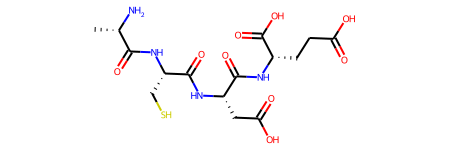

In [6]:
smi, mw, formula = MingDuSeq2smi('Ala-Cys-Asp-Glu')
print("分子式", formula)
print("分子量", mw)
Chem.MolFromSmiles(smi)

分子式 C37H46N6O13S
分子量 814.28


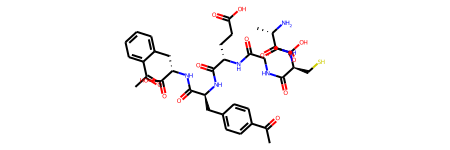

In [7]:
smi, mw, formula = MingDuSeq2smi('Ala-Cys-Asp-Glu-A001-A002')
print("分子式", formula)
print("分子量", mw)
Chem.MolFromSmiles(smi)

# 1-letter 只适用天然氨基酸

分子式 C15H24N4O9S
分子量 436.13


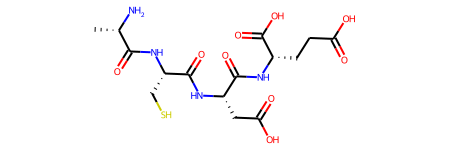

In [8]:
smi, mw, formula = MingDuSeq2smi('ACDE')
print("分子式", formula)
print("分子量", mw)
Chem.MolFromSmiles(smi)

分子式 C15H24N4O9S
分子量 436.13


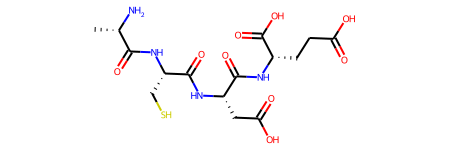

In [9]:
smi, mw, formula = MingDuSeq2smi('A-C-D-E')
print("分子式", formula)
print("分子量", mw)
Chem.MolFromSmiles(smi)